## Курсовой проект для курса "Python для Data Science"

### Задание:
Используя данные из train.csv, построить
модель для предсказания цен на недвижимость (квартиры).
С помощью полученной модели предсказать
цены для квартир из файла test.csv.

### Целевая переменная:
Price

### Метрика:
R2 - коэффициент детерминации (sklearn.metrics.r2_score)

### Описание датасета:
- Id - идентификационный номер квартиры
- DistrictId - идентификационный номер района
- Rooms - количество комнат
- Square - площадь
- LifeSquare - жилая площадь
- KitchenSquare - площадь кухни
- Floor - этаж
- HouseFloor - количество этажей в доме
- HouseYear - год постройки дома
- Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности
- Social_1, Social_2, Social_3 - социальные показатели местности
- Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья
- Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров
- Price - цена квартиры 

### Подключение библиотек и скриптов

In [1]:
import warnings
warnings.filterwarnings('ignore')


import pandas as pd
import numpy as np

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error as mae
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

### Функции

In [2]:
TRAIN_DATASET_PATH = 'train.csv'
TEST_DATASET_PATH = 'test.csv'
TEST_DATASET_EXT_PATH = 'Final Work.ipynb'

In [3]:
# Функция преобразования переменных в булевые.
def obj_to_bool (columns, df):
    for column in columns:
        unique_true = df[column].unique()[1]
        df[column]  = df[column] == unique_true

In [4]:
# Функция для отображения scatter-графика по двум признакам.
def draw_scatter(column_x, column_y, df):
    plt.scatter(df[column_x], df[column_y])
    plt.xlabel(column_x)
    plt.ylabel(column_y)
    plt.show()  

In [5]:
# Функция вырезает из выборки выбросы.
def drop_by_IQ(column, df):
    IQ=df[column].describe()['75%']-df[column].describe()['25%']
    low_border=df[column].describe()['25%']-IQ*1.5
    high_border=df[column].describe()['75%']+IQ*1.5
    
    print('For column {}\n\tIQ:\t{}\n\tLOW:\t{}\n\tHIGH:\t{}\n'.format(column, IQ, low_border, high_border))
    
    size_before = df[column].size
    df.drop(df[(df[column]<low_border)|(df[column]>high_border)].index, axis=0, inplace=True)    
    size_after = df[column].size
    
    lost_percentage = (size_before - size_after) * 100 / size_before 
    print('Lost {}% of data.'.format('%0.2f' % lost_percentage))

In [6]:
# Функция заменяет выбросы в выборке на среднее значение по признаку.
def replace_by_IQ(column, df):
    IQ=df[column].describe()['75%']-df[column].describe()['25%']
    low_border=df[column].describe()['25%']-IQ*1.5
    high_border=df[column].describe()['75%']+IQ*1.5
    mean = df[column].mean()
    
    print('For column {}\n\tIQ:\t{}\n\tLOW:\t{}\n\tHIGH:\t{}\n\tMEAN:\t{}'.format(column, IQ, low_border, high_border, mean))

    index_to_replace = df[(df[column]<low_border)|(df[column]>high_border)].index

    df.loc[index_to_replace, column] = mean
    print('In {} row {} was replaced to {}.'.format(index_to_replace.size, column, mean))

In [7]:
# Функция заполняет пустые значения признака LifeSquare, высчитывая его через общую площадь квартиры.
def fill_life_square(df, coeff):
    df.loc[df['LifeSquare'].isnull(), 'LifeSquare'] = df['Square'] * coeff
    
# Функция заменяет выбросы признака HouseYear средним значением.
def clean_year(df, mean_year):
    df.loc[df['HouseYear'] > 2020, 'HouseYear'] = mean_year

In [8]:
# Функция считает метрику r2_score и mae по переданным наборам данных и модели.
def fit_pred(x_train, y_train, x_test, y_test, model):
    model.fit(x_train, y_train)
    
    y_train_pred = model.predict(x_train) 
    y_test_pred = model.predict(x_test)
    
    r2_train = r2_score(y_train, y_train_pred)
    mae_train = mae(y_train, y_train_pred)
    print(f'r2_train = {r2_train}, mae_train: {mae_train}')
    
    r2_test = r2_score(y_test, y_test_pred)
    mae_test = mae(y_test, y_test_pred)
    print(f'r2_test = {r2_test}, mae_test: {mae_test}')

In [9]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head()

Id  DistrictId  Rooms     Square  LifeSquare  KitchenSquare  Floor  \
0  14038          35    2.0  47.981561   29.442751            6.0      7   
1  15053          41    3.0  65.683640   40.049543            8.0      7   
2   4765          53    2.0  44.947953   29.197612            0.0      8   
3   5809          58    2.0  53.352981   52.731512            9.0      8   
4  10783          99    1.0  39.649192   23.776169            7.0     11   

   HouseFloor  HouseYear  Ecology_1 Ecology_2 Ecology_3  Social_1  Social_2  \
0         9.0       1969   0.089040         B         B        33      7976   
1         9.0       1978   0.000070         B         B        46     10309   
2        12.0       1968   0.049637         B         B        34      7759   
3        17.0       1977   0.437885         B         B        23      5735   
4        12.0       1976   0.012339         B         B        35      5776   

   Social_3  Healthcare_1  Helthcare_2  Shops_1 Shops_2          Price  
0         5           NaN            0       11       B  184966.930730  
1         1         240.0            1       16       B  300009.450063  
2         0         229.0            1        3       B  220925.908524  
3         3        1084.0            0        5       B  175616.227217  
4         1        2078.0            2        4       B  150226.531644

In [10]:
df_test = pd.read_csv(TEST_DATASET_PATH)

### Загрузка данных

In [11]:
train = pd.read_csv(TRAIN_DATASET_PATH)
test = pd.read_csv(TEST_DATASET_PATH)

In [12]:
print(f"Train:\t{train.shape[0]}\t sales and {train.shape[1]} features")
print(f'Test:\t{test.shape[0]}\t sales and {test.shape[1]} features')

Train:	10000	 sales and 20 features
Test:	5000	 sales and 19 features


In [13]:
train.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7887 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Ecology_2      10000 non-null  object 
 11  Ecology_3      10000 non-null  object 
 12  Social_1       10000 non-null  int64  
 13  Social_2       10000 non-null  int64  
 14  Social_3       10000 non-null  int64  
 15  Healthcare_1   5202 non-null   float64
 16  Helthcare_2    10000 non-null  int64  
 17  Shops_1        10000 non-null  int64  
 18  Shops_2

Датасет содержит три признака типа object (`Ecology_2`, `Ecology_3`, `Shops_2`). По двум признакам есть пропущенные значения (`LifeSquare`, `Healthcare_1`).

Сперва избавимся от признаков типа object.

In [14]:
obj_features = df.select_dtypes(include='object').columns
obj_features

Index(['Ecology_2', 'Ecology_3', 'Shops_2'], dtype='object')

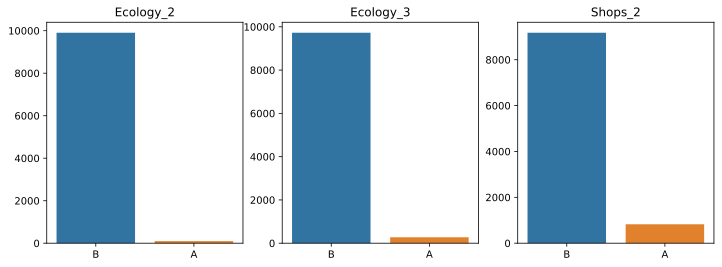

In [15]:
plt.figure(figsize = (12,4))

for i, colname in enumerate(obj_features):
    counts = df[colname].value_counts()
    
    plt.subplot(1,3,i+1)    
    plt.title(colname)
    sns.barplot(counts.index, counts.values)
    
plt.show()

In [16]:
for column in obj_features:
    print('{}\n'.format(df[column].value_counts()))

B    9903
A      97
Name: Ecology_2, dtype: int64

B    9725
A     275
Name: Ecology_3, dtype: int64

B    9175
A     825
Name: Shops_2, dtype: int64



Так как признаки принимают всего два значения, заменим их на бинарные признаки.

In [17]:
obj_to_bool(obj_features, df)

Произведем проверку: если количество значений не изменилось, значит преобразование сделано правильно.

In [18]:
for column in obj_features:
    print('{}\n'.format(df[column].value_counts()))

False    9903
True       97
Name: Ecology_2, dtype: int64

False    9725
True      275
Name: Ecology_3, dtype: int64

False    9175
True      825
Name: Shops_2, dtype: int64



### Подготовка обучающего датасета


Так как признак `Healthcare_1` содержит очень много пропущенных значений (в нем пропущенно почти 50% значений) и мы не знаем, как рассчитывался этот параметр, чтобы попытаться заполнить пропущенное самостоятельно, его можно не учитывать в процессе анализа.

In [19]:
df.drop(['Healthcare_1'], axis=1, inplace=True)

In [20]:
df.describe().transpose()

count           mean            std           min  \
Id             10000.0    8383.407700    4859.019020      0.000000   
DistrictId     10000.0      50.400800      43.587592      0.000000   
Rooms          10000.0       1.890500       0.839512      0.000000   
Square         10000.0      56.315775      21.058732      1.136859   
LifeSquare      7887.0      37.199645      86.241209      0.370619   
KitchenSquare  10000.0       6.273300      28.560917      0.000000   
Floor          10000.0       8.526700       5.241148      1.000000   
HouseFloor     10000.0      12.609400       6.775974      0.000000   
HouseYear      10000.0    3990.166300  200500.261427   1910.000000   
Ecology_1      10000.0       0.118858       0.119025      0.000000   
Social_1       10000.0      24.687000      17.532614      0.000000   
Social_2       10000.0    5352.157400    4006.799803    168.000000   
Social_3       10000.0       8.039200      23.831875      0.000000   
Helthcare_2    10000.0       1.319500       1.493601      0.000000   
Shops_1        10000.0       4.231300       4.806341      0.000000   
Price          10000.0  214138.857399   92872.293865  59174.778028   

                         25%            50%            75%           max  
Id               4169.500000    8394.500000   12592.500000  1.679800e+04  
DistrictId         20.000000      36.000000      75.000000  2.090000e+02  
Rooms               1.000000       2.000000       2.000000  1.900000e+01  
Square             41.774881      52.513310      65.900625  6.410652e+02  
LifeSquare         22.769832      32.781260      45.128803  7.480592e+03  
KitchenSquare       1.000000       6.000000       9.000000  2.014000e+03  
Floor               4.000000       7.000000      12.000000  4.200000e+01  
HouseFloor          9.000000      13.000000      17.000000  1.170000e+02  
HouseYear        1974.000000    1977.000000    2001.000000  2.005201e+07  
Ecology_1           0.017647       0.075424       0.195781  5.218671e-01  
Social_1            6.000000      25.000000      36.000000  7.400000e+01  
Social_2         1564.000000    5285.000000    7227.000000  1.908300e+04  
Social_3            0.000000       2.000000       5.000000  1.410000e+02  
Helthcare_2         0.000000       1.000000       2.000000  6.000000e+00  
Shops_1             1.000000       3.000000       6.000000  2.300000e+01  
Price          153872.633942  192269.644879  249135.462171  6.332335e+05

### Работаем c выбросами

In [21]:
df_num_features = df.select_dtypes(include=['float64', 'int64'])\
    .drop(['Id', 'DistrictId'], axis=1)

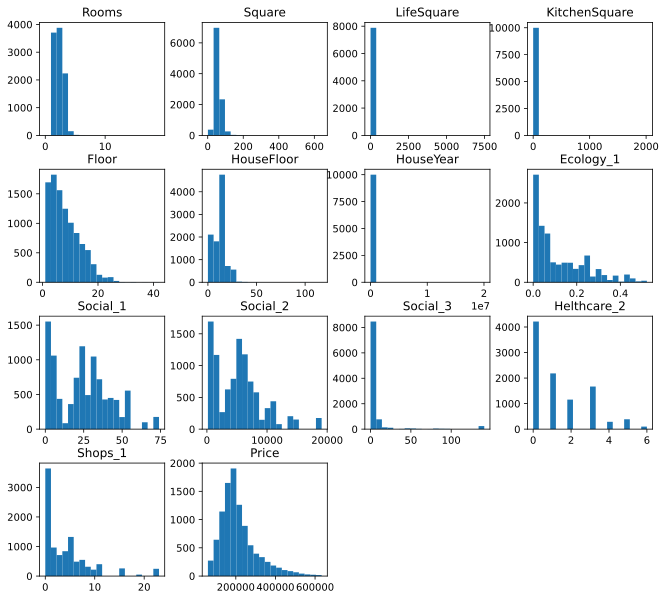

In [22]:
df_num_features.hist(figsize=(11,10), bins=20, grid=False);

#### LifeSquare и Square

Исследуем значения признаков `LifeSquare` и `Square`. Попробуем установить зависимость между жилой площадью и полной площадью квартиры.

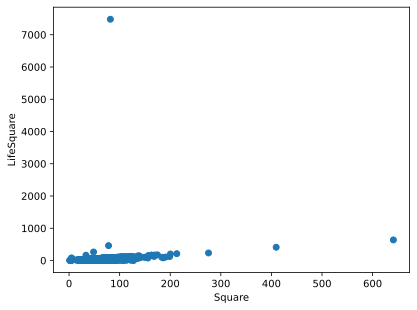

In [23]:
draw_scatter('Square', 'LifeSquare', df)

In [24]:
drop_by_IQ('Square', df)
drop_by_IQ('LifeSquare', df)

For column Square
	IQ:	24.125744426186976
	LOW:	5.586264180189367
	HIGH:	102.08924188493728

Lost 2.42% of data.
For column LifeSquare
	IQ:	21.756925644753355
	LOW:	-9.940131635100524
	HIGH:	77.08757094391291

Lost 1.91% of data.


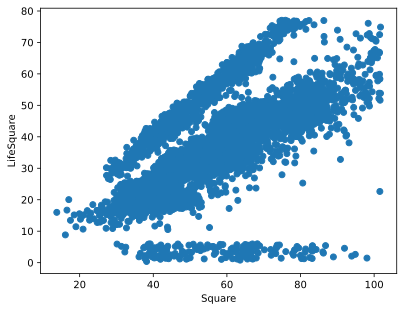

In [25]:
draw_scatter('Square', 'LifeSquare', df)

Найдём долю жилой площади от общей по сроедним значениям в выборке и заполним пропущенные значения в столбце LifeSquare.

In [26]:
square_mean_values = df[['Square', 'LifeSquare']].dropna().mean()
square_coeff = square_mean_values[1] / square_mean_values[0]

fill_life_square(df, square_coeff)

square_coeff

0.6378520569631749

#### KitchenSquare

Признак `KitchenSquare` содержит выбросы. Избавимся от них.

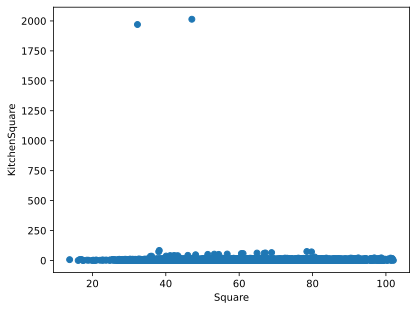

In [27]:
draw_scatter('Square', 'KitchenSquare', df)

In [28]:
replace_by_IQ('KitchenSquare', df)

For column KitchenSquare
	IQ:	8.0
	LOW:	-11.0
	HIGH:	21.0
	MEAN:	6.2431048892603425
In 31 row KitchenSquare was replaced to 6.2431048892603425.


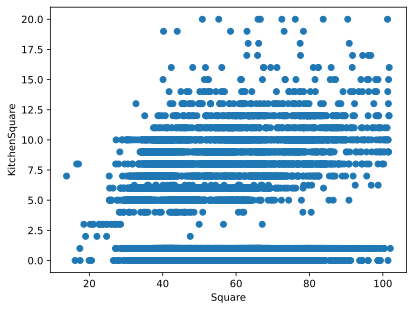

In [29]:
draw_scatter('Square', 'KitchenSquare', df)

#### Rooms

Избавимся от выбрасов в признке `Rooms`.

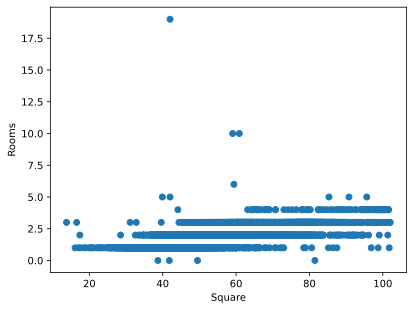

In [30]:
draw_scatter('Square', 'Rooms', df)

In [31]:
replace_by_IQ('Rooms', df)

For column Rooms
	IQ:	1.0
	LOW:	-0.5
	HIGH:	3.5
	MEAN:	1.8459047221061429
In 102 row Rooms was replaced to 1.8459047221061429.


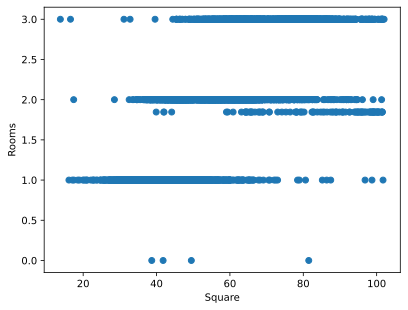

In [32]:
draw_scatter('Square', 'Rooms', df)

#### HouseYear

Признак HouseYear так же содержит выпадающие значения. Обработаем их.

In [33]:
mean_year = np.round(df.loc[df['HouseYear'] <= 2020, 'HouseYear'].mean())
mean_year

1984.0

In [34]:
clean_year(df, mean_year)

Итоговый датасет:

In [35]:
df_num_features = df.select_dtypes(include=['float64', 'int64'])\
    .drop(['Id', 'DistrictId'], axis=1)

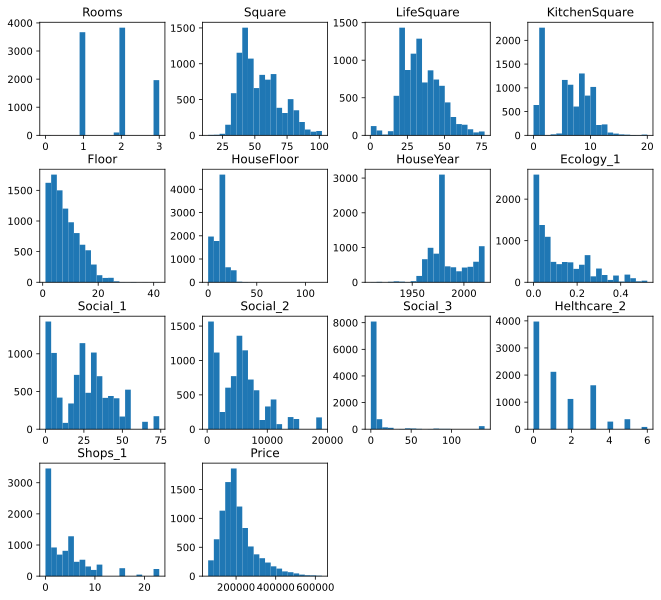

In [36]:
df_num_features.hist(figsize=(11,10), bins=20, grid=False);

В процессе подготовки данных мы заменили избавились от признаков типа object. Исключили из анализа признак `Healthcare_1`. Исключили выбросы из выборки по признакам `Square` и `LifeSquare`. Заменили выбросы по признаку `KitchenSquare` и  `Rooms` на средние значения. И заполнили пропущенные значения по признаку `LifeSquare`. Сделаем то же самое для тестового датафрейма. Однако, вместо исключения выбросов по признакам Square и LifeSquare заменим выбросы на средние значения.

In [37]:
test = pd.read_csv(TEST_DATASET_PATH)
obj_to_bool(obj_features, test)
test.drop(['Healthcare_1'], axis=1, inplace=True)
replace_by_IQ('Square', test)
replace_by_IQ('LifeSquare', test)
fill_life_square(test, square_coeff)
replace_by_IQ('KitchenSquare', test)

For column Square
	IQ:	24.37889829487171
	LOW:	5.337883253363636
	HIGH:	102.85347643285048
	MEAN:	56.44950036381242
In 110 row Square was replaced to 56.44950036381242.
For column LifeSquare
	IQ:	22.082065205778463
	LOW:	-10.031071759483922
	HIGH:	78.29718906362993
	MEAN:	36.15881045508673
In 118 row LifeSquare was replaced to 36.15881045508673.
For column KitchenSquare
	IQ:	8.0
	LOW:	-11.0
	HIGH:	21.0
	MEAN:	5.9768
In 19 row KitchenSquare was replaced to 5.9768.


Разобьем тестовый датасет на тестовый и валидационный.

In [38]:
features = df.columns.drop('Id').drop('DistrictId').drop('Price')
target = 'Price'

In [39]:
X = pd.DataFrame(df, columns=features)
y = pd.DataFrame(df, columns=[target])

In [40]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=42)

In [41]:
X_test = test[features]
X_test.head().transpose()

0          1          2          3          4
Rooms                2.0        2.0        1.0        2.0        1.0
Square         49.882643  69.263183  13.597819  73.046609  47.527111
LifeSquare     33.432782  44.179664  15.948246  51.940842  43.387569
KitchenSquare        6.0        1.0       12.0        9.0        1.0
Floor                  6          6          2         22         17
HouseFloor          14.0        1.0        5.0       22.0       17.0
HouseYear           1972       1977       1909       2007       2017
Ecology_1       0.310199   0.075779        0.0   0.101872   0.072158
Ecology_2          False      False      False      False      False
Ecology_3          False      False      False      False      False
Social_1              11          6         30         23          2
Social_2            2748       1437       7538       4583        629
Social_3               1          3         87          3          1
Helthcare_2            0          0          5          3          0
Shops_1                0          2          5          3          0
Shops_2            False      False      False      False       True

Масштабируем данные.

In [42]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=features)
X_valid_scaled = pd.DataFrame(scaler.transform(X_valid), columns=features)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=features)

In [43]:
model = RandomForestRegressor(n_estimators=1000, max_depth=9, max_features=7, random_state=42)
fit_pred(X_train_scaled, y_train, X_valid_scaled, y_valid, model)

r2_train = 0.8166551562888227, mae_train: 24459.367916065232
r2_test = 0.6800563952430245, mae_test: 30119.770315281134


Предсказываем цены для тестового датасета и выгружаем результат в файл. На сайте kaggle.com результат 0.688.

In [44]:
price = model.predict(X_test_scaled)
pd.DataFrame({ 'Id': test['Id'], 'Price': price }).to_csv(TEST_DATASET_EXT_PATH, index=False)